In [ ]:
import torch

embeddings = torch.tensor([
    [ 1.3, 0.01, 0.00],
    [ 1.1, 0.01, 0.00],
    [ 1.0, 0.01, 0.00],
    [-1.0, 0.01, 0.00],
    [-1.1, 0.01, 0.00],
    [-1.3, 0.01, 0.00],
], dtype=torch.float32)

labels_enc = torch.tensor([0, 0, 1, 0, 1, 1], dtype=torch.long)
sim_matrix = torch.nn.functional.cosine_similarity(
    embeddings.unsqueeze(1),
    embeddings.unsqueeze(0),
    dim=2
)

APs = []
N = len(embeddings)
for i in range(N):
    sims = sim_matrix[i].clone()
    # push self-sim to -inf so it never shows up in topk
    sims[i] = -float('inf')

    # get the top N-1 most similar *other* samples
    k = N - 1
    topk_vals, topk_idx = torch.topk(sims, k=k, largest=True)

    # now compute relevant mask and precision
    relevant = (labels_enc[topk_idx] == labels_enc[i]).float()
    cum_relevant = torch.cumsum(relevant, dim=0)
    precision_at_k = cum_relevant / (torch.arange(k).float() + 1.0)

    # AP is just the mean precision over the relevant positions
    if relevant.sum() > 0:
        AP = precision_at_k[relevant.bool()].mean()
    else:
        AP = torch.tensor(0.0)

    APs.append(AP)

APs = torch.stack(APs)
mAP = APs.mean()

print("Average Precision per query:", APs.tolist())
print("Mean Average Precision (mAP):", mAP.item())


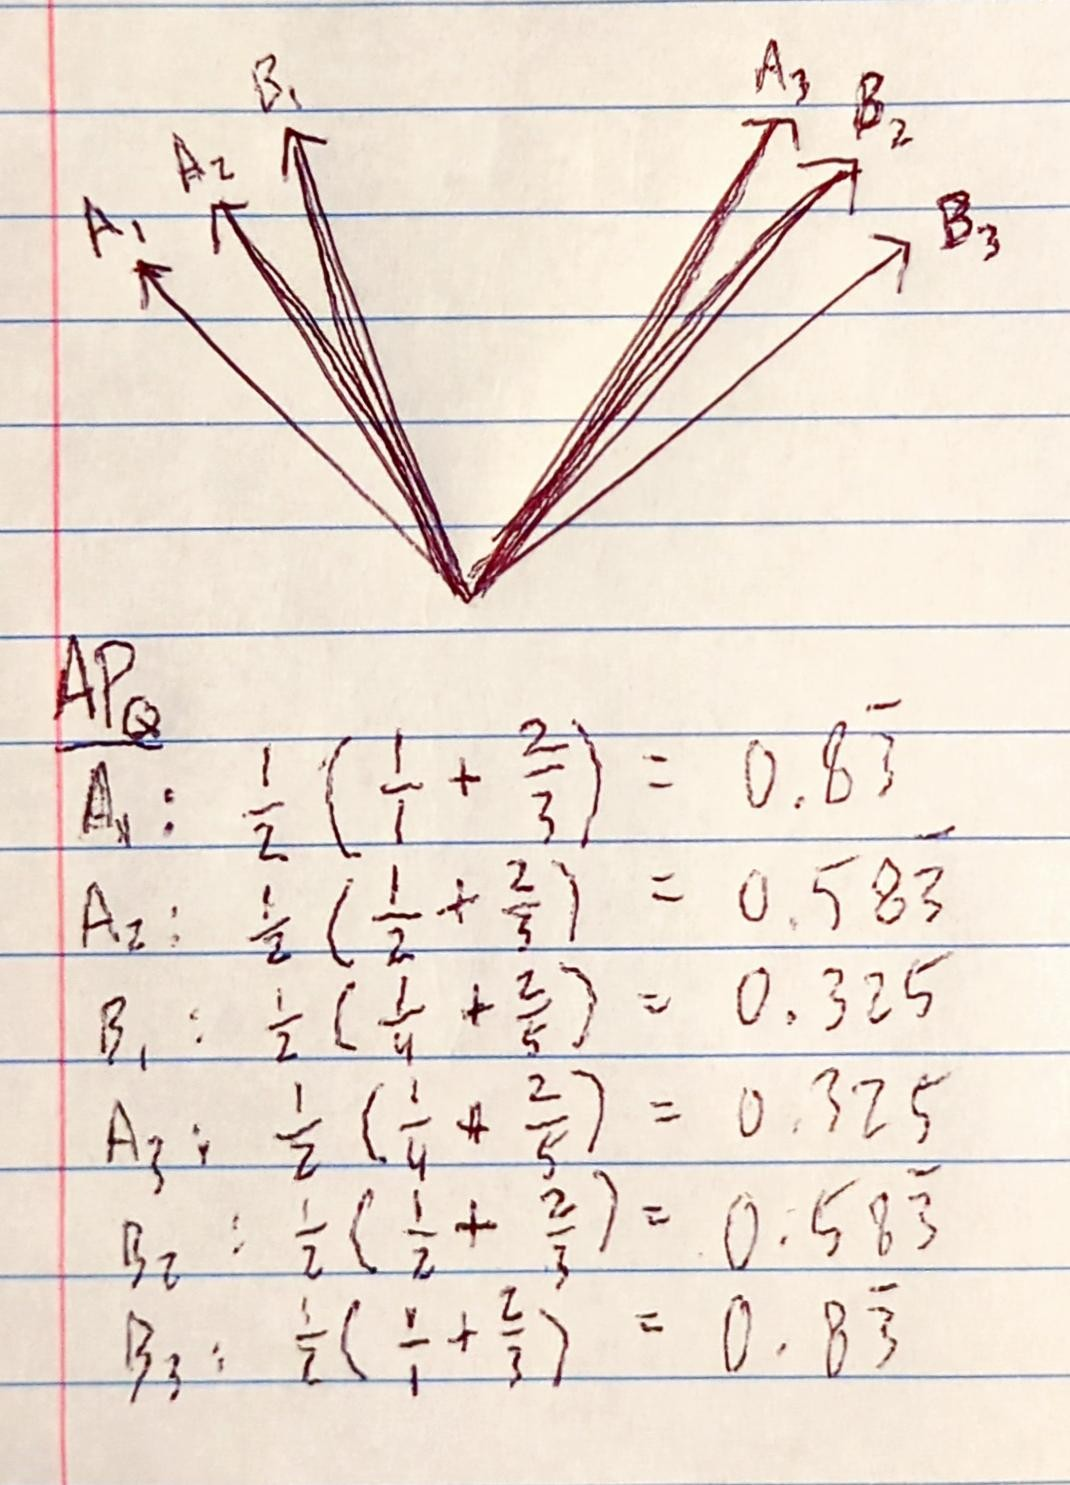